In [24]:
import pandas as pd
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import string
import nltk
import en_core_web_sm
#nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm')
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
import random
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [2]:
dftry2 = pd.read_csv("posts_st.txt",
                    sep = '|',
                    names = ['AUTHOR','ID','SCORE','CREATED_DATE','TITLE','NUM_COMMENTS','SELFTEXT'],
                    header=None, lineterminator = "\n")

### Removing where the title or the selftext are null and removing the posts where the moderator for the Subreddit deleted/removed the post or the original author deleted/removed the post.

In [3]:
dftry2.dropna(subset=['TITLE'], inplace = True)
dftry2.dropna(subset=['SELFTEXT'], inplace = True)
df_touse = dftry2[dftry2['SELFTEXT'] != "[removed]"].copy()
df_to_use_fin = df_touse[df_touse['SELFTEXT'] != "[deleted]"].copy()
df_to_use_fin['FULL_POSTS'] = df_to_use_fin['TITLE']+"."+" "+df_touse['SELFTEXT']

### Only keeping posts from the release date of season 3 to current.  This just mirrors our supervised learning portion - although unrelated to one another except for both surround Stranger Things - we did not expect to bring back so much data from the pushshift api.

In [4]:
df_to_use_fin['CREATED_DATE'] = pd.to_datetime(df_to_use_fin['CREATED_DATE'])
df_to_use_fin = df_to_use_fin[df_to_use_fin['CREATED_DATE']> "2019-07-04"].copy()

### Text Cleaning Function, removes web address which holds links and appears when someone posts a png or jpg. They do many hand drawings of characters or scenes from the show in the subreddit. Then the function sets text to lower case and then removes all punctuation. Then utilizing spacy nlp we find the words lemma and then kick it out if it is a stop words, or is an instance of non alpha characters (such as numbers), then it removes if the word itself is less than 2 chars and finally removes the word if the word's part of speech is not in the allowed parts of speech list we have.

In [5]:
# Text Cleaning Function
import re

def clean(text):
    allowed_postags=["NOUN", "VERB", "ADJ", "ADV", "ADP", "PROPN"]
    
    try: 
        text1 = re.sub(r"http\S+", "", text)
        #Convert text in lower case
        text2 = text1.lower()
        #text3 = text2.replace("[^a-zA-Z#]", " ")
        #Removing Punctuations
        punc_removed = text2.translate(str.maketrans('', '', string.punctuation))
        doc= nlp(punc_removed)
        text_out = [token.lemma_ for token in doc if token.is_stop == False and \
                    token.is_alpha and len(token)>2 and token.pos_ in allowed_postags\
                   ]
        #txt = ' '.join(text_out)
    except:
        #txt = ''
        text_out = ''
    return text_out

In [6]:
df_to_use_fin['token_lemma'] = df_to_use_fin['FULL_POSTS'].apply(clean)

### Getting the sentiment by utilizing vader 

In [10]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def polarity(text):
    pol = sid.polarity_scores(text)
    return pol
#polarity checking
def joiner(text):
    txt = ' '.join(text)
    return txt
df_to_use_fin['FULL_POSTS_CLEAN'] = df_to_use_fin['token_lemma'].apply(joiner)
df_to_use_fin['polarity'] = df_to_use_fin['FULL_POSTS_CLEAN'].apply(polarity)
df_to_use_fin['compound']  = df_to_use_fin['polarity'].apply(lambda score_dict: score_dict['compound'])

df_to_use_fin['sentiment'] = df_to_use_fin['compound'].apply(lambda x: "Positive" if x>0 else("Negative" if x<0 else "Neutral") )
print("polarity checked successfull")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacquelineskunda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


polarity checked successfull


### Removal of posts where the tokenized and lemmatized title+selftext, aka POSTS, have a length less than 5.  We believe this will help create more defined topics and also alleviates the issues where the poster only posted a short blurb of words and some sort of image/vid or a hyperlink elsewhere.

In [11]:
df_to_use_fin['tok_len'] = df_to_use_fin['token_lemma'].apply(lambda x: len(x))
df_to_use_fin.groupby(['tok_len'])['tok_len'].count()[2759]
df_to_use_fin = df_to_use_fin[df_to_use_fin['tok_len']>=5].copy()
#checking shape to see how much data we have
df_to_use_fin.shape

(30660, 14)

### Vectorization method - TF_IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
tf_idf_vectorizor = TfidfVectorizer(max_features = 20000) #1
tf_idf = tf_idf_vectorizor.fit_transform(list(df_to_use_fin['FULL_POSTS_CLEAN'])) #2
#tf_idf_array = tf_idf.toarray() 
pd.DataFrame(tf_idf.toarray(),columns=tf_idf_vectorizor.get_feature_names()).head() #4

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,aaaaaaaaaaaa,aaaaand,aaron,ab,aback,abacus,abandon,abandonment,abc,...,zimmerman,zip,zippo,zodiac,zombie,zombieboy,zone,zoom,zoomer,zuggtmoy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Kmeans clustering

In [16]:
#Looking at Kmeans using standard 10 topics for K

num_clusters = 10
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(tf_idf)
kmeans_clusters = kmeans.predict(tf_idf)
kmeans_distances = kmeans.transform(tf_idf)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizor.get_feature_names_out()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 flayer
 mind
 vecna
 upside
 season

Cluster 1:
 song
 play
 season
 music
 know

Cluster 2:
 vecna
 max
 kill
 think
 theory

Cluster 3:
 strange
 thing
 watch
 season
 stranger

Cluster 4:
 steve
 nancy
 robin
 jonathan
 season

Cluster 5:
 upside
 gate
 open
 demogorgon
 season

Cluster 6:
 hopper
 russian
 joyce
 american
 season

Cluster 7:
 season
 watch
 episode
 think
 like

Cluster 8:
 character
 mike
 like
 season
 think

Cluster 9:
 think
 know
 like
 season
 episode



/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Finding Ideal number of topics

### Elbow Method

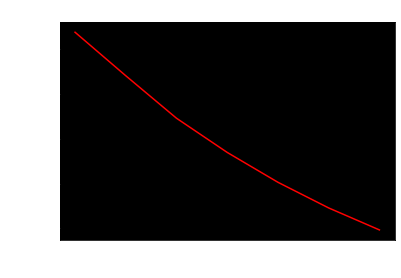

In [21]:
Sum_of_squared_distances = []
K = range(4,22,2)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters,init='k-means++', 
                          random_state = 100,
                         verbose=10, max_iter=1000)
    kmeans.fit(tf_idf)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.rcParams['axes.facecolor'] = 'black'
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
plt.plot(K,Sum_of_squared_distances,'r-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

### The elbow method is not distinguishing a great K, this could be due to the data coming all from the same subreddit so it is not exhibiting well seperated clusters.  Also this means we will have to try a silouhette score instead which will help determine a ideal k.
"The silhouette value for each point is a measure of how similar that point is to points in its own cluster compared to points in other clusters, and ranges from -1 to +1.

The silhouette value for the ith point, Si, is defined as

Si = (bi-ai)/ max(ai,bi) where ai is the average distance from the ith point to the other points in the same cluster as i, and bi is the minimum average distance from the ith point to points in a different cluster, minimized over clusters."

### Silouhette Score

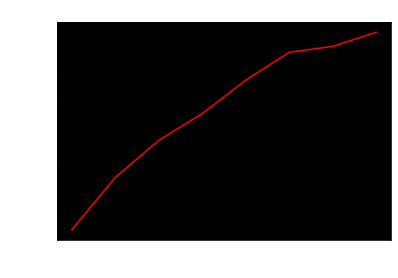

In [25]:
range_n_clusters = [4,6,8,10,12,14,16,18]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans_sil = KMeans(n_clusters=num_clusters,init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)
    kmeans_sil.fit(tf_idf)
    cluster_labels = kmeans_sil.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(tf_idf, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'r-')
plt.rcParams['axes.facecolor'] = 'black'
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### Look into using grid search with cv for hyper parameter tuning

### Using KMeans with ideal number of Topics

### Hyper parameter tuning with ideal k-topics

### Tuned Kmeans Final output